In [1]:
import os
os.environ['TAVILY_API_KEY'] = 'your API key'
from langchain.globals import set_debug,set_verbose
model_id = 'anthropic.claude-3-haiku-20240307-v1:0'

In [ ]:
from langchain_aws import ChatBedrockConverse
from langchain_core.messages import SystemMessage,HumanMessage,AIMessage
llm = ChatBedrockConverse(model=model_id,temperature=0)

In [3]:
from langchain_community.tools.tavily_search import TavilySearchResults
search_tool = TavilySearchResults(max_results=2)

In [4]:
import operator
from typing import Annotated, List, Tuple, TypedDict

class PlanExecute(TypedDict):
    input: str
    plan: List[str]
    past_steps: Annotated[List[Tuple], operator.add]
    response: str

In [5]:

from langchain_core.pydantic_v1 import BaseModel, Field
from typing import Union,Optional

class Plan(BaseModel):
    """Plan to follow in future"""

    steps: List[str] = Field(
        description="different steps to follow, should be in sorted order"
    )

class Response(BaseModel):
    """Response to user."""

    # response: str
    response: str = Field(
        description="response to user"
    )


class Act(BaseModel):
    """Action to perform."""

    action: Union[Response, Plan] = Field(
        description="""Action to perform. Based on past steps, respond to user if information is sufficient; else plan for more steps. If you want to respond to user, use Response."""
        
    )


In [6]:
tools = [search_tool]

In [7]:
from langchain import hub
from langgraph.prebuilt import create_react_agent
prompt = hub.pull("wfh/react-agent-executor")
# prompt.pretty_print()

# create_react_agent includes binding of tools
agent_executor = create_react_agent(llm, tools, messages_modifier=prompt)

In [8]:

def plan_step(state: PlanExecute):
    system_message = SystemMessage("""For the given objective, come up with a simple step by step plan. \
This plan should involve individual tasks, that if executed correctly will yield the correct answer. Do not add any superfluous steps. \
The result of the final step should be the final answer. Make sure that each step has all the information needed - do not skip steps.""")
    user_message = HumanMessage(state['input'])
    llm_with_structured_output = llm.with_structured_output(Plan)
    plan = llm_with_structured_output.invoke([system_message,user_message])
    return {'plan':plan.steps}

In [ ]:
# test plan_step
dict = PlanExecute(input='what is the hometown of the current Australia open winner?')
output = plan_step(dict)
output

In [9]:
def replan_step(state: PlanExecute):
    prompt_template = """For the given objective, come up with a simple step by step plan. \
This plan should involve individual tasks, that if executed correctly will yield the correct answer. Do not add any superfluous steps. \
The result of the final step should be the final answer. Make sure that each step has all the information needed - do not skip steps.

Your objective was this:
{input}

Your original plan was this:
{plan}

You have currently done the follow steps:
{past_steps}

Update your plan accordingly. If no more steps are needed and you can return to the user, then respond with that. Otherwise, fill out the plan. Only add steps to the plan that still NEED to be done. Do not return previously done steps as part of the plan."""
    prompt_filled = prompt_template.format(input=state['input'],plan=state['plan'],past_steps=state['past_steps'])
    human_message = HumanMessage(prompt_filled)
    llm_with_structured_output = llm.with_structured_output(Act)
    replan = llm_with_structured_output.invoke([human_message])

    if isinstance(replan.action,Response):
        return {'response':replan.action.response}
    elif isinstance(replan.action,Plan):
        return {'plan':replan.action.steps}

In [ ]:
# test replan_step with test output
dict = PlanExecute(input='what is the hometown of the current Australia open winner?',plan=['1. Identify the current winner of the Australian Open',
  '2. Look up the hometown of the current Australian Open winner'],past_steps=[])
output = replan_step(dict)
output

In [ ]:
# test replan_step with response output
# state = {'input': 'what is the hometown of the 2024 Australia open winner?', 'plan': ["3. Report the hometown of Jannik Sinner, the 2024 Australian Open men's singles champion"], 'past_steps': [('1. Identify the winner of the 2024 Australia Open', "Based on the search results, it appears that Jannik Sinner of Italy won the 2024 Australian Open men's singles title. He defeated Daniil Medvedev in a 5-set comeback victory, becoming the first Italian man to win the Australian Open since 1976.\n\nThe key details are:\n\n- Jannik Sinner of Italy won the 2024 Australian Open men's singles title\n- He defeated Daniil Medvedev in a 5-set match, coming back from a 2-set deficit\n- This was Sinner's first Grand Slam title\n- He became the first Italian man to win the Australian Open since 1976\n\nSo in summary, the winner of the 2024 Australian Open men's singles title was Jannik Sinner of Italy."), ("2. Look up the hometown of Jannik Sinner, the 2024 Australian Open men's singles champion", "Based on the search results, Jannik Sinner's hometown is Sexten in the Dolomites region of Italy. The information from the ATP Tour article directly states that Sinner is from the town of Sexten."), ("3. Report the hometown of Jannik Sinner, the 2024 Australian Open men's singles champion", "Based on the search results, Jannik Sinner's hometown is Sexten, located in the Dolomites region of Italy. The results indicate that Sinner is from this small town in the Dolomite mountains.")], 'response': None}
state = {'input': 'what is the hometown of the 2024 Australia open winner?', 'plan': ['1. Identify the current Australia Open winner', '2. Research the hometown of the current Australia Open winner', '3. Provide the hometown of the current Australia Open winner'], 'past_steps': [('1. Identify the winner of the 2024 Australia Open', "Based on the search results, it appears that Jannik Sinner of Italy won the 2024 Australian Open men's singles title. He defeated Daniil Medvedev in a 5-set comeback victory, becoming the first Italian man to win the Australian Open since 1976.\n\nThe key details are:\n\n- Jannik Sinner of Italy won the 2024 Australian Open men's singles title\n- He defeated Daniil Medvedev in a 5-set match, coming back from a 2-set deficit\n- This was Sinner's first Grand Slam title\n- He became the first Italian man to win the Australian Open since 1976\n\nSo in summary, the winner of the 2024 Australian Open men's singles title was Jannik Sinner of Italy."), ("2. Look up the hometown of Jannik Sinner, the 2024 Australian Open men's singles champion", "Based on the search results, Jannik Sinner's hometown is Sexten in the Dolomites region of Italy. The information from the ATP Tour article directly states that Sinner is from the town of Sexten."), ("3. Report the hometown of Jannik Sinner, the 2024 Australian Open men's singles champion", "Based on the search results, Jannik Sinner's hometown is Sexten, located in the Dolomites region of Italy. The results indicate that Sinner is from this small town in the Dolomite mountains.")], 'response': None}
dict = PlanExecute(state)
output = replan_step(dict)
output

In [10]:
def execute_step(state: PlanExecute):
    plan = state['plan']
    prompt_template = """For the following plan:
{plan}\n\nYou are tasked with executing step {task}."""
    prompt_filled = prompt_template.format(plan='\n'.join(plan),task=plan[0])
    human_message = HumanMessage(prompt_filled)

    agent_response = agent_executor.invoke(
        {"messages": human_message}
    )
    return {
        "past_steps": [(plan[0], agent_response["messages"][-1].content)],
    }
    


In [ ]:
# test execute_step
dict = PlanExecute(plan=['1. Look up who the current winner of the Australian Open is',
  '2. Determine the hometown of the current Australian Open winner'])
output = execute_step(dict)
output

In [11]:
def should_end(state: PlanExecute):
    if "response" in state and state["response"]:
        return "__end__"
    else:
        return "agent"

In [12]:
from langgraph.graph import StateGraph, START, END

workflow = StateGraph(PlanExecute)

# Add the plan node
workflow.add_node("planner", plan_step)

# Add the execution step
workflow.add_node("agent", execute_step)

# Add a replan node
workflow.add_node("replan", replan_step)

workflow.add_edge(START, "planner")

# From plan we go to agent
workflow.add_edge("planner", "agent")

# From agent, we replan
workflow.add_edge("agent", "replan")

workflow.add_conditional_edges(
    "replan",
    # Pass in the function that will determine which node is called next.
    should_end,
    {'agent':'agent','__end__':END}
)

app = workflow.compile()

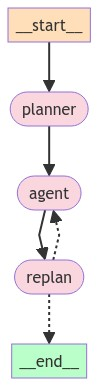

In [13]:
from IPython.display import Image, display

display(Image(app.get_graph(xray=True).draw_mermaid_png()))

In [15]:
config = {"recursion_limit": 10}
inputs = {"input": "what is the hometown of the 2024 Australia open winner?"}
for event in app.stream(inputs, config=config):
    for k, v in event.items():
        if k != "__end__":
            print('k',k)
            print('v',v)            

k planner
v {'plan': ['1. Identify the winner of the 2024 Australia Open', '2. Find the hometown of the 2024 Australia Open winner']}
k agent
v {'past_steps': [('1. Identify the winner of the 2024 Australia Open', "Based on the search results, the winner of the 2024 Australian Open was Jannik Sinner. The key details are:\n\n- Jannik Sinner beat Daniil Medvedev in the 2024 Australian Open men's final.\n- Sinner was the youngest player to win the Australian Open men's title since Novak Djokovic in 2008.\n- Sinner won the first Australian Open men's final since 2005 that did not feature Roger Federer, Rafael Nadal or Novak Djokovic.\n\nSo the winner of the 2024 Australian Open was Jannik Sinner.")]}
k replan
v {'plan': ['2. Find the hometown of Jannik Sinner, the 2024 Australian Open winner']}
k agent
v {'past_steps': [('2. Find the hometown of Jannik Sinner, the 2024 Australian Open winner', 'Based on the search results, Jannik Sinner\'s hometown is Sexten, located in northern Italy. The